---

Reproduce the results from:

Abi Jaber, Illand, and Li (2023). *[The quintic Ornstein-Uhlenbeck volatility model that jointly
calibrates SPX & VIX smiles](https://arxiv.org/pdf/2212.10917)*

---

# Imports

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import quintic
from scipy import integrate

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
SEED = 1234
COLORS = sns.color_palette("tab10")

# Simulation

## SPX smile

Define quintic parameters and initial forward variance curve

In [5]:
params = {
    "rho": -0.65,
    "H": -0.1,
    "eps": 1 / 52,
    "a_vec": [0.01, 1, 0.214, 0.227],
}


def xi0(t):
    """Initial forward variance curve."""
    return 0.02 * np.ones_like(t)

Define maturity, log-moneyness grid, and Monte Carlo parameters

In [17]:
Ts = np.array([1 / 12, 3 / 12, 6 / 12])  # expiries
n_steps = 600  # time steps
n_mc = 5 * 10**4  # Monte Carlo paths
S0 = 1.0
ks = np.linspace(-0.2, 0.03, 50)  # log-moneyness k = log(K/S0)
Ks = np.exp(ks) * S0  # strikes

Compute implied volatilities via Monte Carlo. 

Antithetic variates and control variates 
can be used to reduce variance.

In [18]:
# dictionary to hold implied volatilities for each maturity
impvols = {
    T: quintic.simulate_quintic_ou(
        params=params,
        xi0=xi0,
        T=T,
        k=ks,
        n_steps=n_steps,
        n_mc=n_mc,
        seed=SEED,
        antithetic=True,
    )
    for T in Ts
}

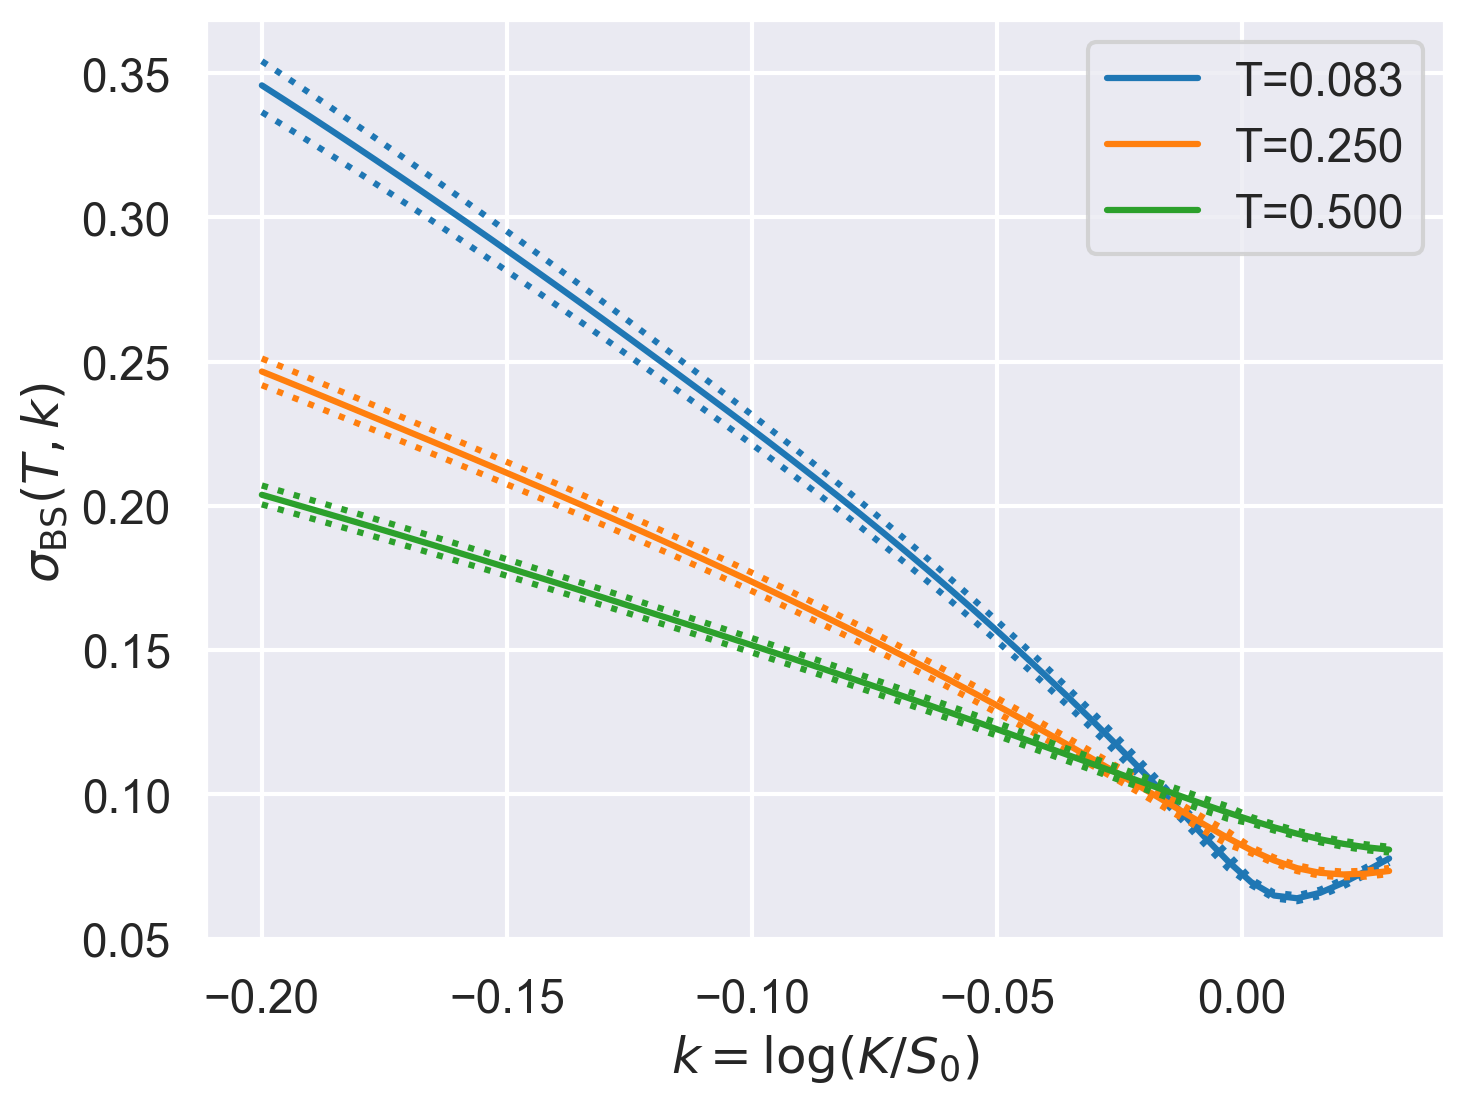

In [22]:
fig, ax = plt.subplots()
for i, T in enumerate(Ts):
    ax.plot(ks, impvols[T]["otm_impvol"], "-", color=COLORS[i], label=f"T={T:.3f}")
    ax.plot(
        ks,
        impvols[T]["otm_impvol_high"],
        ":",
        color=COLORS[i],
    )
    ax.plot(
        ks,
        impvols[T]["otm_impvol_low"],
        ":",
        color=COLORS[i],
    )
ax.set_xlabel(r"$k = \log(K/S_0)$")
ax.set_ylabel(r"$\sigma_{\text{BS}}(T, k)$")
ax.legend()
plt.show()

## VIX smile

Define number of quadrature points and log-moneyness grid

In [ ]:
n_quad = 100
ks = np.linspace(-0.1, 1, 50)

Compute VIX implied volatilties

In [35]:
impvol_vix = {
    T: quintic.impvol_vix(T=T, k=ks, params=params, xi0=xi0, n_quad=n_quad) for T in Ts
}
fut_vix = {T: quintic.fut_vix(T=T, params=params, xi0=xi0, n_quad=n_quad) for T in Ts}

Plot VIX implied volatilities wrt log-moneyness

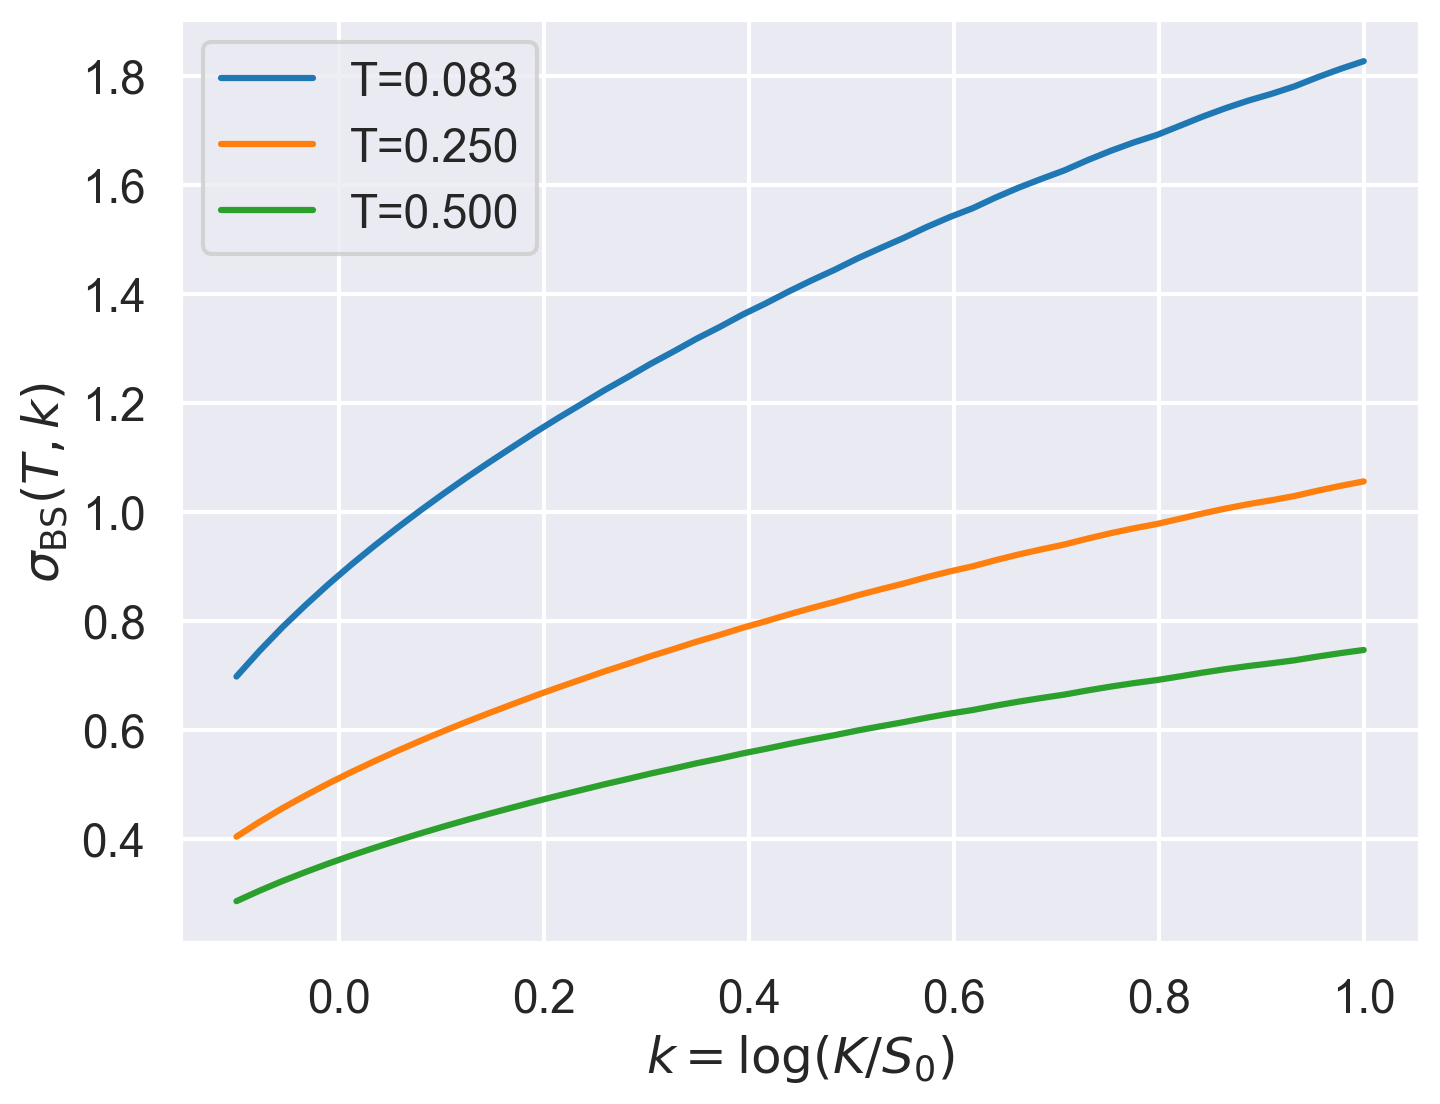

In [36]:
fig, ax = plt.subplots()
for i, T in enumerate(Ts):
    ax.plot(ks, impvol_vix[T], "-", color=COLORS[i], label=f"T={T:.3f}")
ax.set_xlabel(r"$k = \log(K/S_0)$")
ax.set_ylabel(r"$\sigma_{\text{BS}}(T, k)$")
ax.legend()
plt.show()

Plot VIX implied volatilities wrt strike

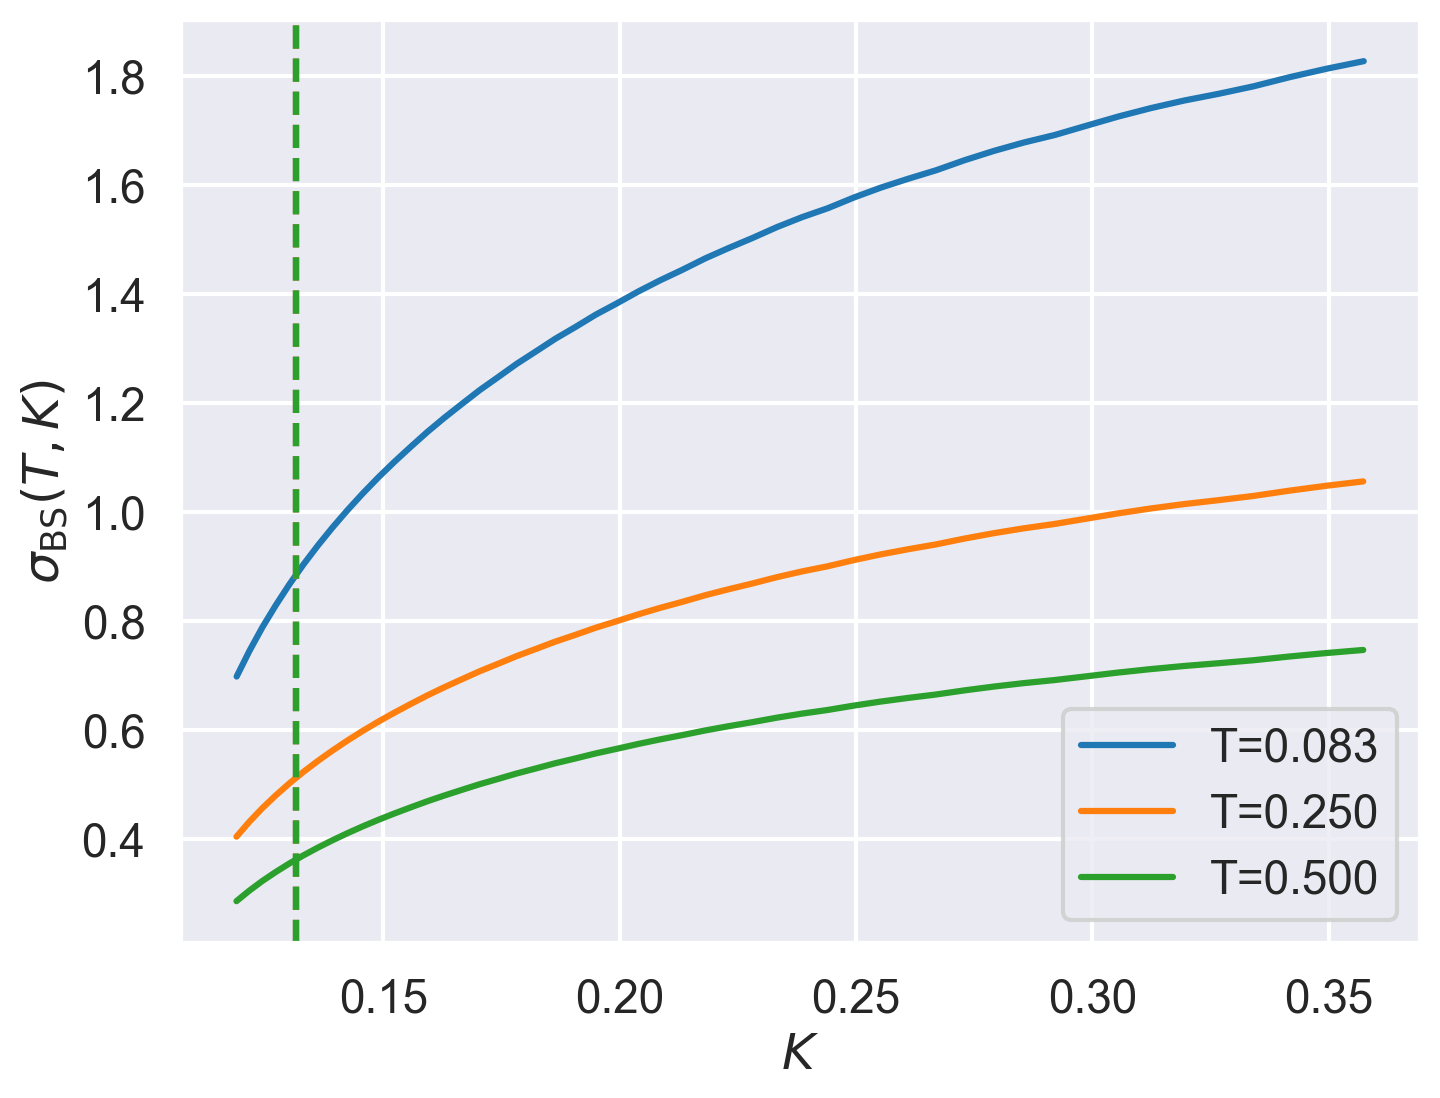

In [37]:
fig, ax = plt.subplots()
for i, T in enumerate(Ts):
    Ks = fut_vix[T] * np.exp(ks)
    ax.plot(Ks, impvol_vix[T], "-", color=COLORS[i], label=f"T={T:.3f}")
    ax.axvline(fut_vix[T], color=COLORS[i], linestyle="--")
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"$\sigma_{\text{BS}}(T, K)$")
ax.legend()
plt.show()